In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect

In [10]:
engine = create_engine("sqlite:///../app/data/hawaii.sqlite")

#check on the database to see what it 'looks like'


In [11]:
inspector = inspect(engine)
print(inspector.get_table_names())

OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: http://sqlalche.me/e/13/e3q8)

In [3]:
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

NameError: name 'inspector' is not defined

In [4]:
columns = inspector.get_columns("station")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [25]:
query = """
        Select 
            *
        from
            station
        limit 100
        """

In [26]:
conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

In [27]:
df.tail()

,id,station,name,latitude,longitude,elevation
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


# Precipitation Analysis

In [22]:
# https://stackoverflow.com/questions/13519124/add-numbers-of-day-to-date-sqlite
getLastYearMeasures = ""
with open("getLastYearMeasures.sql", "r") as f:
    getLastYearMeasures = f.read()

In [23]:
getLastYearMeasures

"SELECT\n    date,\n    prcp\nFROM\n    measurement\nWHERE\n    date >= (\n                SELECT\n                   date(MAX(date), '-365 day')\n                FROM\n                    measurement\n            )\nORDER BY\n    date"

In [24]:
conn = engine.connect()
df = pd.read_sql(getLastYearMeasures, con=conn)
conn.close()

In [21]:
df["date"] = pd.to_datetime(df["date"])
df.head()

# only had to do if bringing back all rows
# maxDate = df.loc[len(df) - 1, "date"]
# startDate = maxDate - datetime.timedelta(days=365)

# #filter to last year
# df_sub = df.loc[df["date"] >= startDate].reset_index(drop=True)
# df_sub.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


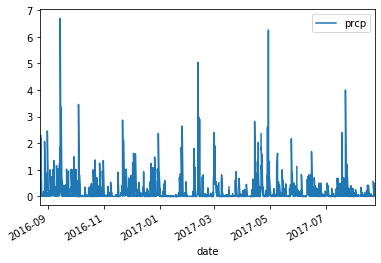

In [11]:
df.set_index("date").plot()

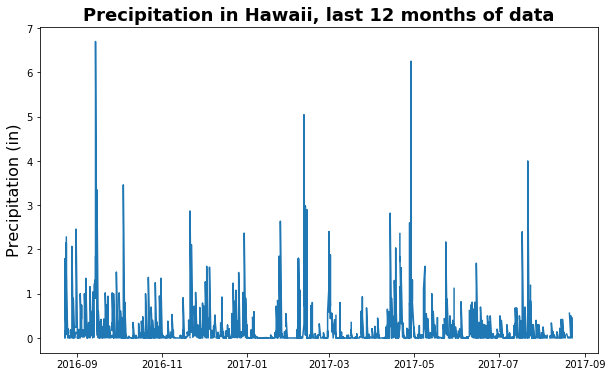

In [12]:
plt.figure(figsize=(10,6))
plt.plot(df.date, df.prcp)
plt.title("Precipitation in Hawaii, last 12 months of data", fontweight="bold", fontsize=18)
plt.ylabel("Precipitation (in)", fontsize=16)
plt.xlabel("")

plt.show()

In [14]:
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Stations

In [31]:
query = """
        SELECT
            count(*) as station_count
        FROM
            station
        """

In [32]:
conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

df

,station_count
0,9


In [37]:
query = """
        SELECT
        s.station,
        count(*) as tot_obs
        FROM
            station s
        JOIN measurement m on s.station = m.station
        GROUP BY s.station
        ORDER BY
            count(*) desc
        """

In [38]:
conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

df

,station,tot_obs
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [48]:
query = """
        SELECT
            m.date,
            m.prcp,
            m.tobs,
            s.station,
            s.name
        FROM
            measurement m
            join station s on m.station = s.station
        WHERE
            date >= (
                        SELECT
                           date(MAX(date), '-365 day')
                        FROM
                            measurement
                    )
        ORDER BY
            date
        """

In [49]:
conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

df

,date,prcp,tobs,station,name
0,2016-08-23,0.00,81.0,USC00519397,"WAIKIKI 717.2, HI US"
1,2016-08-23,0.15,76.0,USC00513117,"KANEOHE 838.1, HI US"
2,2016-08-23,0.05,80.0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
3,2016-08-23,NaN,80.0,USC00517948,"PEARL CITY, HI US"
4,2016-08-23,0.02,80.0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"
...,...,...,...,...,...
2225,2017-08-22,0.50,76.0,USC00516128,"MANOA LYON ARBO 785.2, HI US"
2226,2017-08-23,0.00,81.0,USC00519397,"WAIKIKI 717.2, HI US"
2227,2017-08-23,0.00,82.0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
2228,2017-08-23,0.08,82.0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"


In [50]:
df.groupby("station").size().sort_values(ascending=False)

station
USC00519397    361
USC00519281    352
USC00516128    349
USC00513117    343
USC00519523    337
USC00514830    305
USC00517948    183
dtype: int64

In [52]:
mostActive = df.groupby("station").size().sort_values(ascending=False).index[0]
mostActive

'USC00519397'

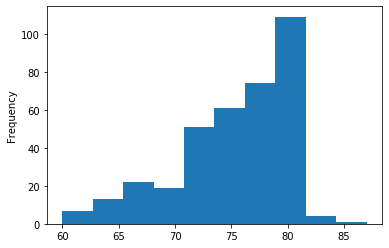

In [54]:
df.loc[df.station == mostActive, "tobs"].reset_index(drop=True).plot(kind="hist")

In [56]:
df_sub = df.loc[df.station == mostActive].reset_index(drop=True)

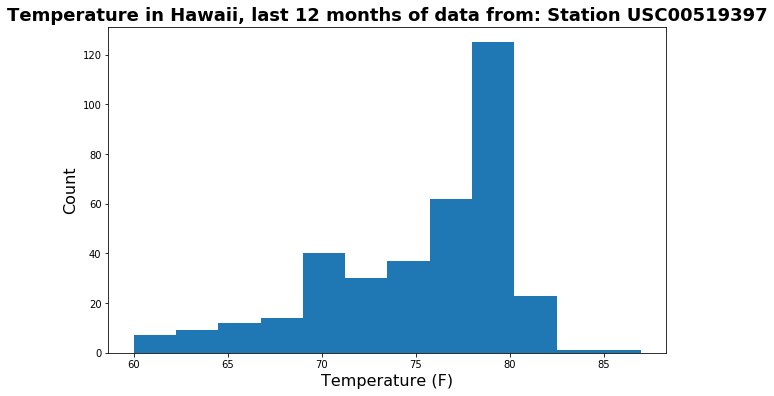

In [63]:
plt.figure(figsize=(10,6))
plt.hist(df_sub.tobs, bins=12)
plt.title(f"Temperature in Hawaii, last 12 months of data from: Station {mostActive}", fontweight="bold", fontsize=18)
plt.ylabel("Count", fontsize=16)
plt.xlabel("Temperature (F)", fontsize=16)

plt.show()

In [64]:
df_sub.describe()

,prcp,tobs
count,359.000000,361.000000
mean,0.044819,75.210526
std,0.188810,4.963758
min,0.000000,60.000000
25%,0.000000,72.000000
50%,0.000000,77.000000
75%,0.020000,79.000000
max,2.620000,87.000000
